In [5]:
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_csv("application_record.csv", na_values="#N/D")

In [7]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [8]:
# cargo el otro dataset con el historial crediticio de los ID
df2 = pd.read_csv("credit_record.csv", na_values="#N/D")
df2 = df2.rename(columns = {"MONTHS_BALANCE" : "months_balance", "STATUS": "status"})

In [9]:
# creo una variable que mida la antiguedad de la cuenta en la variable months_balance
age_account = pd.DataFrame(df2.groupby(["ID"])["months_balance"].agg(min))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7864\1198856979.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  age_account = pd.DataFrame(df2.groupby(["ID"])["months_balance"].agg(min))


In [10]:
# uno los datasets para que solo los que tengasn historial crediticio queden (ya que sin historial crediticio no podemos predecir)
df = pd.merge(df, age_account, how="left", on="ID")

df2.loc[df2["status"].isin(["0", "1", "x", "C"]), "status"] = "no"
df2.loc[df2["status"].isin(["2", "3", "4", "5"]), "status"] = "yes"

boolstat = df2.groupby("ID")["status"].agg(lambda x: "yes" if (x == "yes").any() else "no").reset_index()

df = pd.merge(df, boolstat, how = "inner", on = "ID")

In [11]:
# creo la variable target
df["high_risk"] = df["status"]

df["high_risk"] = df["status"].map({"yes": 1, "no": 0})

df.drop("status", axis = 1, inplace=True)

In [12]:
df = df.rename(columns={
    "CODE_GENDER": "gender", "FLAG_OWN_CAR": "own_car", "FLAG_OWN_REALTY": "own_property",
    "CNT_CHILDREN": "children", "AMT_INCOME_TOTAL": "income", "NAME_INCOME_TYPE": "income_type",
    "NAME_EDUCATION_TYPE": "education_type", "NAME_FAMILY_STATUS": "family_status", "NAME_HOUSING_TYPE": "house_type",
    "DAYS_BIRTH": "age", "DAYS_EMPLOYED": "days_employed", "FLAG_MOBIL": "own_mobile_phone",
    "FLAG_WORK_PHONE": "own_work_phone", "FLAG_PHONE": "own_phone", "FLAG_EMAIL": "own_email",
    "OCCUPATION_TYPE": "occupation_type", "CNT_FAM_MEMBERS": "family_members", "months_balance": "months_balance"
})

In [13]:
df

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,1


In [14]:
df_original = df

In [15]:
# separo el dataset en train y test set
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [16]:
df_train_original, df_test_original = data_split(df, 0.2)


In [17]:
x_train_original = df_train_original.drop("high_risk", axis=1) 
y_train_original = df_train_original["high_risk"]

In [18]:
df_train_original.shape
(29165, 20)
df_test_original.shape
(7292, 20)

(7292, 20)

In [19]:
#df_train_original.to_csv("train.csv",index=False)
#df_test_original.to_csv("test.csv",index=False)

In [20]:

# creating a copy of the dataset so that the original stays untouched
df_train_copy = df_train_original.copy()
df_test_copy = df_test_original.copy()

In [21]:
df_train_original.shape

(29165, 20)

In [22]:
df_test_original.shape

(7292, 20)

In [23]:
df.describe(include="all")

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
count,3.645700e+04,36457,36457,36457,36457.000000,3.645700e+04,36457,36457,36457,36457,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,25134,36457.000000,36457.000000,36457.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN
freq,NaN,24430,22614,24506,NaN,NaN,18819,24777,25048,32548,NaN,NaN,NaN,NaN,NaN,NaN,6211,NaN,NaN,NaN
mean,5.078227e+06,NaN,NaN,NaN,0.430315,1.866857e+05,NaN,NaN,NaN,NaN,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,NaN,2.198453,-26.164193,0.016897
std,4.187524e+04,NaN,NaN,NaN,0.742367,1.017892e+05,NaN,NaN,NaN,NaN,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,NaN,0.911686,16.501854,0.128886
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000,-60.000000,0.000000
25%,5.042028e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-39.000000,0.000000
50%,5.074614e+06,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-24.000000,0.000000
75%,5.115396e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000,-12.000000,0.000000


In [24]:
df.head()

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   gender            36457 non-null  object 
 2   own_car           36457 non-null  object 
 3   own_property      36457 non-null  object 
 4   children          36457 non-null  int64  
 5   income            36457 non-null  float64
 6   income_type       36457 non-null  object 
 7   education_type    36457 non-null  object 
 8   family_status     36457 non-null  object 
 9   house_type        36457 non-null  object 
 10  age               36457 non-null  int64  
 11  days_employed     36457 non-null  int64  
 12  own_mobile_phone  36457 non-null  int64  
 13  own_work_phone    36457 non-null  int64  
 14  own_phone         36457 non-null  int64  
 15  own_email         36457 non-null  int64  
 16  occupation_type   25134 non-null  object

In [26]:
df["occupation_type"].unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [27]:
df.isna().sum().sort_values(ascending=False)

occupation_type     11323
ID                      0
own_car                 0
gender                  0
own_property            0
children                0
income_type             0
income                  0
family_status           0
house_type              0
age                     0
education_type          0
days_employed           0
own_mobile_phone        0
own_phone               0
own_work_phone          0
own_email               0
family_members          0
months_balance          0
high_risk               0
dtype: int64

In [28]:
# occupation_type tiene demasiados valores nulos 

In [29]:
df.duplicated().sum()

np.int64(0)

In [30]:
# paso la variable high_risk temporalmente a objeto para que se pueda ver su distribución

In [31]:
df["high_risk"] = df["high_risk"].astype("O")

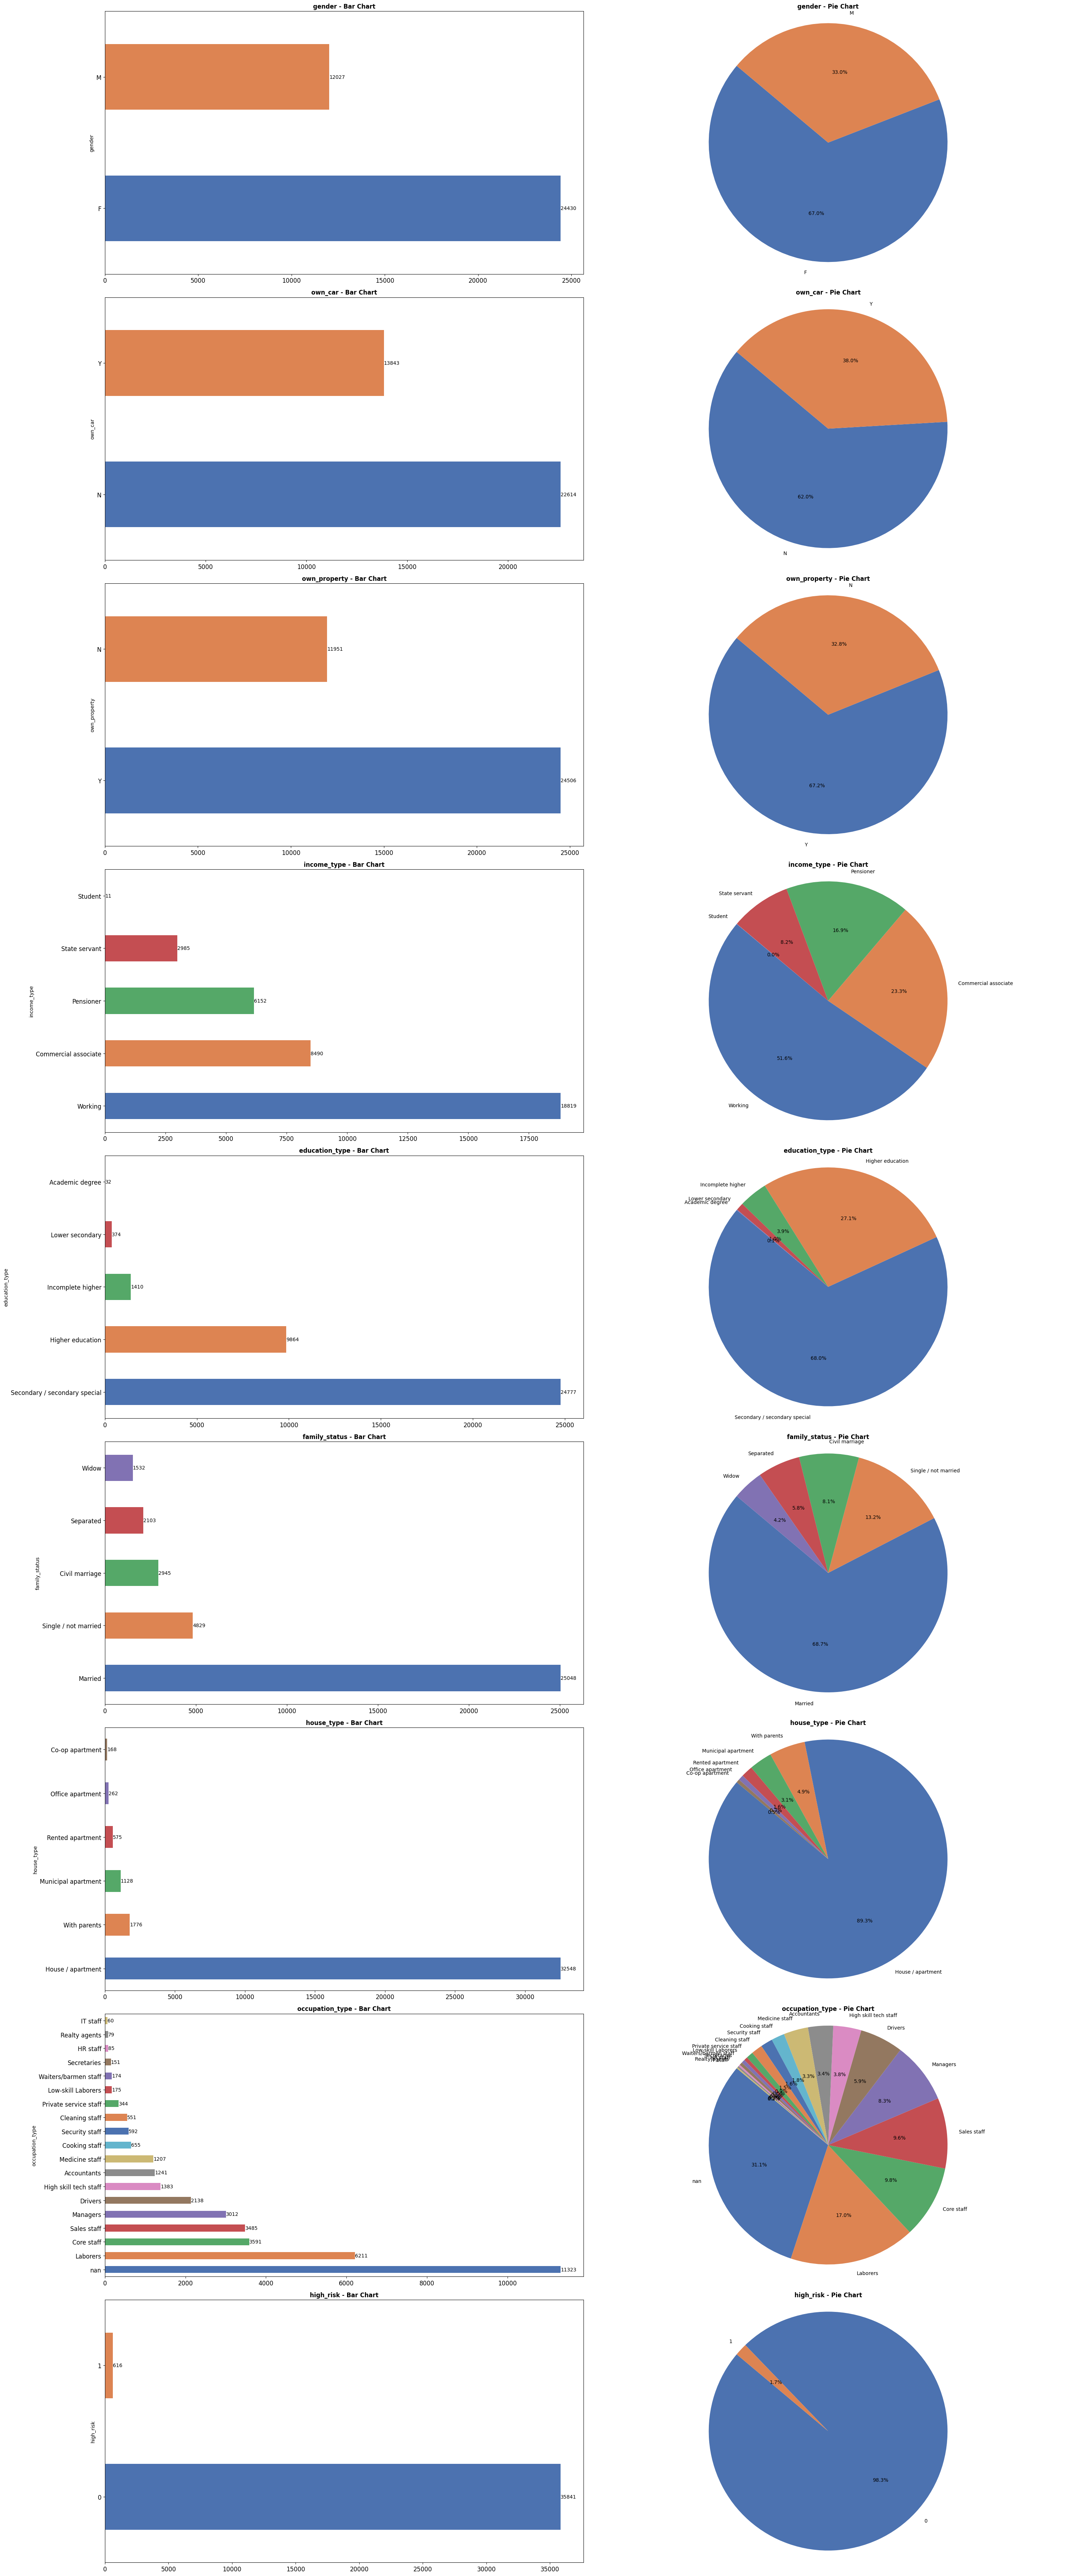

In [32]:
def graficos_eda_categorico(cat):
    # obtengo la lista de las variables categoricas
    categorical_vars = cat.select_dtypes(include=["object"]).columns.tolist()
    num_vars = len(categorical_vars)  # y las cuento
    
    # cuantas filas necesito?
    filas = ceil(num_vars)

    # creo y estructuro la figura y los ejes
    f, ax = plt.subplots(nrows=filas, ncols=2, figsize=(30, filas * 8))

    # aplano los ejes para facilitar el indexing
    ax = ax.flatten()

    # creo un loop para crear los graficos
    for cada, variable in enumerate(categorical_vars):
        value_counts = cat[variable].value_counts(dropna=False)
        unique_values = value_counts.index.tolist()
        num_unique = len(unique_values)
        color_palette = sns.color_palette("deep", n_colors=num_unique)
        
        # barchart
        bar = cat[variable].value_counts(dropna=False).plot.barh(ax=ax[cada*2], color=color_palette)
        ax[cada * 2].set_title(f"{variable} - Bar Chart", fontsize=12, fontweight="bold")
        ax[cada * 2].tick_params(labelsize=12)

        for bar in bar.patches:
            ax[cada*2].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"{int(bar.get_width())}",
                            va="center", ha="left", fontsize=10)

        # piechart
        occupation_count = cat[variable].value_counts(dropna=False)
        if cada * 2 + 1 < len(ax):
            ax[cada * 2 + 1].pie(occupation_count, labels=occupation_count.index, autopct="%1.1f%%", startangle=140, colors=color_palette)
            ax[cada * 2 + 1].set_title(f"{variable} - Pie Chart", fontsize=12, fontweight="bold")
            ax[cada * 2 + 1].axis("equal")

    plt.tight_layout()
    plt.show()

graficos_eda_categorico(df)

In [33]:
df["high_risk"] = df["high_risk"].astype("int")

In [34]:
# podemos ver como nos encontramos frente a un dataset imbalanceado, por lo que deberemos solucionarlo con algún método de resampling (oversampling para la minority class o undersampling para la majority class) o de class weighting

In [35]:
# queda pendiente resolver los "NaN" de occupation_type, es casi un tercio del total de datos por lo que probablemente haya que droppear la variable, este es el peor escenario ya que antes habria que considerar reemplazarlo por la moda debido a que es una variable categorica

In [36]:
# no se ven mas problemas "anormales" en los graficos
# ahora vamos a revisar las variables numericas

In [37]:
def metrica_continuo(num):
    metricas = num.describe().T
    metricas["median"] = num.median()
    metricas = metricas.iloc[:,[0,1,8,2,3,4,5,6,7]] # mediana al lado de la media
    return metricas

In [38]:
metrica_continuo(df.select_dtypes("number"))

,count,mean,median,std,min,25%,50%,75%,max
ID,36457.0,5.078227e+06,5074614.0,41875.240788,5008804.0,5042028.0,5074614.0,5115396.0,5150487.0
children,36457.0,4.303152e-01,0.0,0.742367,0.0,0.0,0.0,1.0,19.0
income,36457.0,1.866857e+05,157500.0,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
age,36457.0,-1.597517e+04,-15563.0,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
days_employed,36457.0,5.926294e+04,-1552.0,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
own_mobile_phone,36457.0,1.000000e+00,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
own_work_phone,36457.0,2.255260e-01,0.0,0.417934,0.0,0.0,0.0,0.0,1.0
own_phone,36457.0,2.948131e-01,0.0,0.455965,0.0,0.0,0.0,1.0,1.0
own_email,36457.0,8.972214e-02,0.0,0.285787,0.0,0.0,0.0,0.0,1.0
family_members,36457.0,2.198453e+00,2.0,0.911686,1.0,2.0,2.0,3.0,20.0


In [39]:
df["own_mobile_phone"].unique()

array([1])

In [40]:
# la variable own_mobile_phone tiene solo un valor, por lo que se elimina

In [41]:
# day_employed tiene un valor maximo (que significa desempleado/retirado) de 365243, por lo que serian practicamente 1000 años desde que esta desempleado (retirado), verifiquemos si es un error de typeo 

In [42]:
sorted = df.sort_values(by= "days_employed", ascending=False)
sorted

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
20868,5089829,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22976,365243,1,0,0,0,NaN,1.0,-7.0,0
36418,5139446,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21256,365243,1,0,1,0,NaN,1.0,-16.0,1
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-17.0,0
8125,5036870,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21821,365243,1,0,0,0,NaN,2.0,-37.0,0
30397,5125585,F,N,Y,0,121500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22571,365243,1,0,1,0,NaN,2.0,-35.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34907,5148705,F,N,Y,0,126000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-22659,-15661,1,0,0,0,Core staff,2.0,-23.0,0
34906,5148704,F,N,Y,0,126000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-22659,-15661,1,0,0,0,Core staff,2.0,-20.0,0
34905,5148703,F,N,Y,0,126000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-22659,-15661,1,0,0,0,Core staff,2.0,-36.0,0
34904,5148702,F,N,Y,0,126000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-22659,-15661,1,0,0,0,Core staff,2.0,-57.0,0


In [43]:
(df["days_employed"]>0).sum()

# efectivamente hay 6135 

np.int64(6135)

In [44]:
(df["income_type"] == "Pensioner").sum()

np.int64(6152)

In [45]:
((df["income_type"] == "Pensioner") & (df["days_employed"]>0)).sum()

np.int64(6135)

In [46]:
# todos los retirados son pensionados correctamente pero no todos los pensionados estan retirados (todavia estan trabajando)

In [47]:
df

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,1


In [48]:
df.isnull().sum().sort_values(ascending=False)

occupation_type     11323
ID                      0
own_car                 0
gender                  0
own_property            0
children                0
income_type             0
income                  0
family_status           0
house_type              0
age                     0
education_type          0
days_employed           0
own_mobile_phone        0
own_phone               0
own_work_phone          0
own_email               0
family_members          0
months_balance          0
high_risk               0
dtype: int64

In [49]:
# corroboramos que no haya ningún "NaN"

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   gender            36457 non-null  object 
 2   own_car           36457 non-null  object 
 3   own_property      36457 non-null  object 
 4   children          36457 non-null  int64  
 5   income            36457 non-null  float64
 6   income_type       36457 non-null  object 
 7   education_type    36457 non-null  object 
 8   family_status     36457 non-null  object 
 9   house_type        36457 non-null  object 
 10  age               36457 non-null  int64  
 11  days_employed     36457 non-null  int64  
 12  own_mobile_phone  36457 non-null  int64  
 13  own_work_phone    36457 non-null  int64  
 14  own_phone         36457 non-null  int64  
 15  own_email         36457 non-null  int64  
 16  occupation_type   25134 non-null  object

In [51]:
df["income"].describe()

count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: income, dtype: float64

In [52]:
df["income"].median()

np.float64(157500.0)

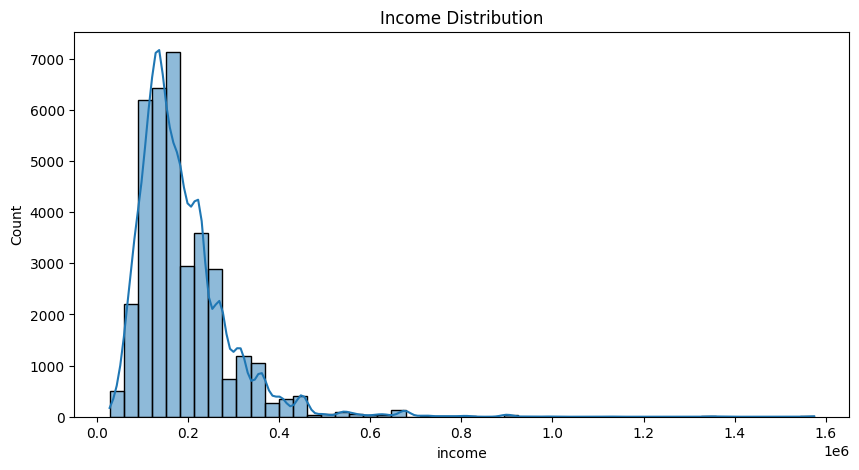

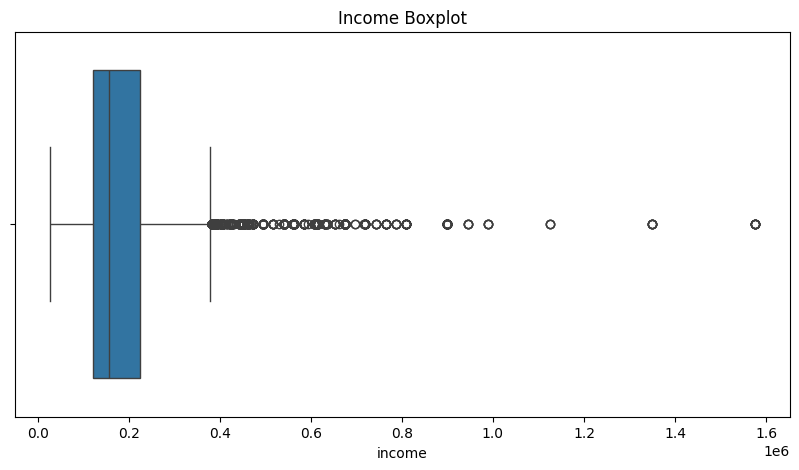

In [53]:
plt.figure(figsize=(10,5))

# Histogram
sns.histplot(df["income"], bins=50, kde=True)
plt.title("Income Distribution")
plt.show()

# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x=df["income"])
plt.title("Income Boxplot")
plt.show()

In [54]:
# se pueden observar claros outliers, habra que ajustarlo
# ademas se puede ver una asimetria en la distribución del income 

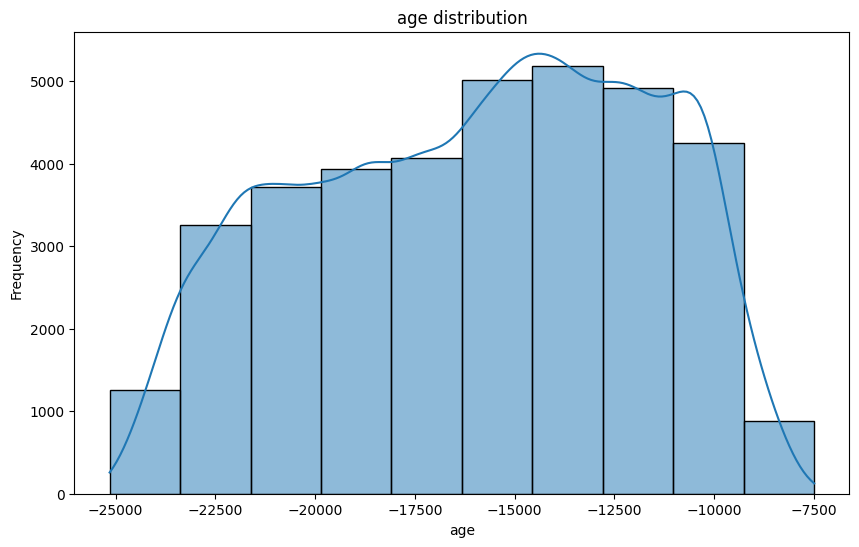

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=10, kde=True)
plt.title("age distribution")
plt.xlabel("age")
plt.ylabel("Frequency")
plt.show()

In [56]:
# tambien hay asimetria en la distribución de age, hay que considerarlo

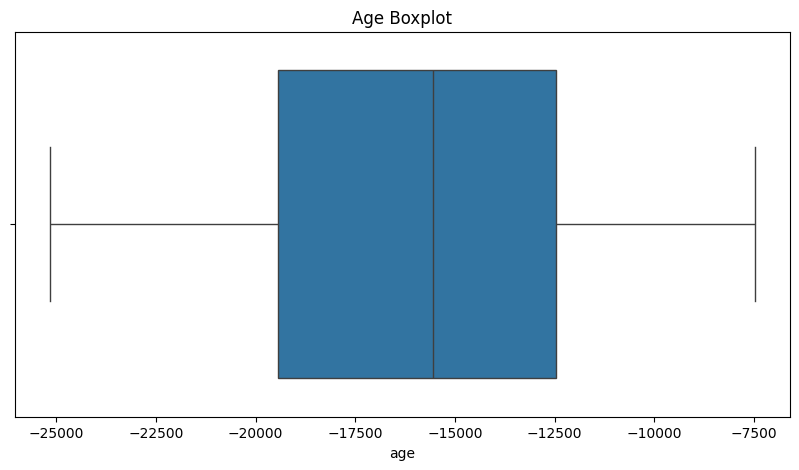

In [57]:
# Boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x=df["age"])
plt.title("Age Boxplot")
plt.show()

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   gender            36457 non-null  object 
 2   own_car           36457 non-null  object 
 3   own_property      36457 non-null  object 
 4   children          36457 non-null  int64  
 5   income            36457 non-null  float64
 6   income_type       36457 non-null  object 
 7   education_type    36457 non-null  object 
 8   family_status     36457 non-null  object 
 9   house_type        36457 non-null  object 
 10  age               36457 non-null  int64  
 11  days_employed     36457 non-null  int64  
 12  own_mobile_phone  36457 non-null  int64  
 13  own_work_phone    36457 non-null  int64  
 14  own_phone         36457 non-null  int64  
 15  own_email         36457 non-null  int64  
 16  occupation_type   25134 non-null  object

In [59]:
def metrica_continuo(num):
    metricas = num.describe().T
    metricas["median"] = num.median()
    metricas = metricas.iloc[:,[0,1,8,2,3,4,5,6,7]]
    return metricas

In [60]:
metrica_continuo(df.select_dtypes("number"))

,count,mean,median,std,min,25%,50%,75%,max
ID,36457.0,5.078227e+06,5074614.0,41875.240788,5008804.0,5042028.0,5074614.0,5115396.0,5150487.0
children,36457.0,4.303152e-01,0.0,0.742367,0.0,0.0,0.0,1.0,19.0
income,36457.0,1.866857e+05,157500.0,101789.226482,27000.0,121500.0,157500.0,225000.0,1575000.0
age,36457.0,-1.597517e+04,-15563.0,4200.549944,-25152.0,-19438.0,-15563.0,-12462.0,-7489.0
days_employed,36457.0,5.926294e+04,-1552.0,137651.334859,-15713.0,-3153.0,-1552.0,-408.0,365243.0
own_mobile_phone,36457.0,1.000000e+00,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
own_work_phone,36457.0,2.255260e-01,0.0,0.417934,0.0,0.0,0.0,0.0,1.0
own_phone,36457.0,2.948131e-01,0.0,0.455965,0.0,0.0,0.0,1.0,1.0
own_email,36457.0,8.972214e-02,0.0,0.285787,0.0,0.0,0.0,0.0,1.0
family_members,36457.0,2.198453e+00,2.0,0.911686,1.0,2.0,2.0,3.0,20.0


In [61]:
# como conclusión del EDA podemos decir que el cliente promedio es:
# femenino, tiene 2 personas en el grupo familiar y esta casada (por lo que es un casamiento sin hijos)
# trabaja y tiene almenos estudios secundarios completos
# no tiene coche, pero tiene propiedad, tiene una casa/apartamento
# tiene email pero no tiene telefono fijo(todos tienen telefono mobil, esto se sabe gracias a la variable own_mobile_phone, la cual tenia que tenia un único valor "True")
# esta hace menos de 5 años en el empleo
# su ingreso es en promedio de unos $160780 y cuenta con una edad promedio de 42 años (para ambos generos)
# la cuenta promedio tiene una antiguedad de 24 meses

In [62]:
# el 98.3% es de bajo riesgo para el prestamo 

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   gender            36457 non-null  object 
 2   own_car           36457 non-null  object 
 3   own_property      36457 non-null  object 
 4   children          36457 non-null  int64  
 5   income            36457 non-null  float64
 6   income_type       36457 non-null  object 
 7   education_type    36457 non-null  object 
 8   family_status     36457 non-null  object 
 9   house_type        36457 non-null  object 
 10  age               36457 non-null  int64  
 11  days_employed     36457 non-null  int64  
 12  own_mobile_phone  36457 non-null  int64  
 13  own_work_phone    36457 non-null  int64  
 14  own_phone         36457 non-null  int64  
 15  own_email         36457 non-null  int64  
 16  occupation_type   25134 non-null  object

In [64]:
df["high_risk"].unique()

array([0, 1])

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   gender            36457 non-null  object 
 2   own_car           36457 non-null  object 
 3   own_property      36457 non-null  object 
 4   children          36457 non-null  int64  
 5   income            36457 non-null  float64
 6   income_type       36457 non-null  object 
 7   education_type    36457 non-null  object 
 8   family_status     36457 non-null  object 
 9   house_type        36457 non-null  object 
 10  age               36457 non-null  int64  
 11  days_employed     36457 non-null  int64  
 12  own_mobile_phone  36457 non-null  int64  
 13  own_work_phone    36457 non-null  int64  
 14  own_phone         36457 non-null  int64  
 15  own_email         36457 non-null  int64  
 16  occupation_type   25134 non-null  object

In [66]:
#hago un heatmap de correlacion de las variables

In [67]:
# creo un dataframe temporal para visualizar el heatmap sin el unico valor de "own_mobile_phone"(aparece fila y columna vacia)
df_temp = df.drop(columns=["own_mobile_phone"])

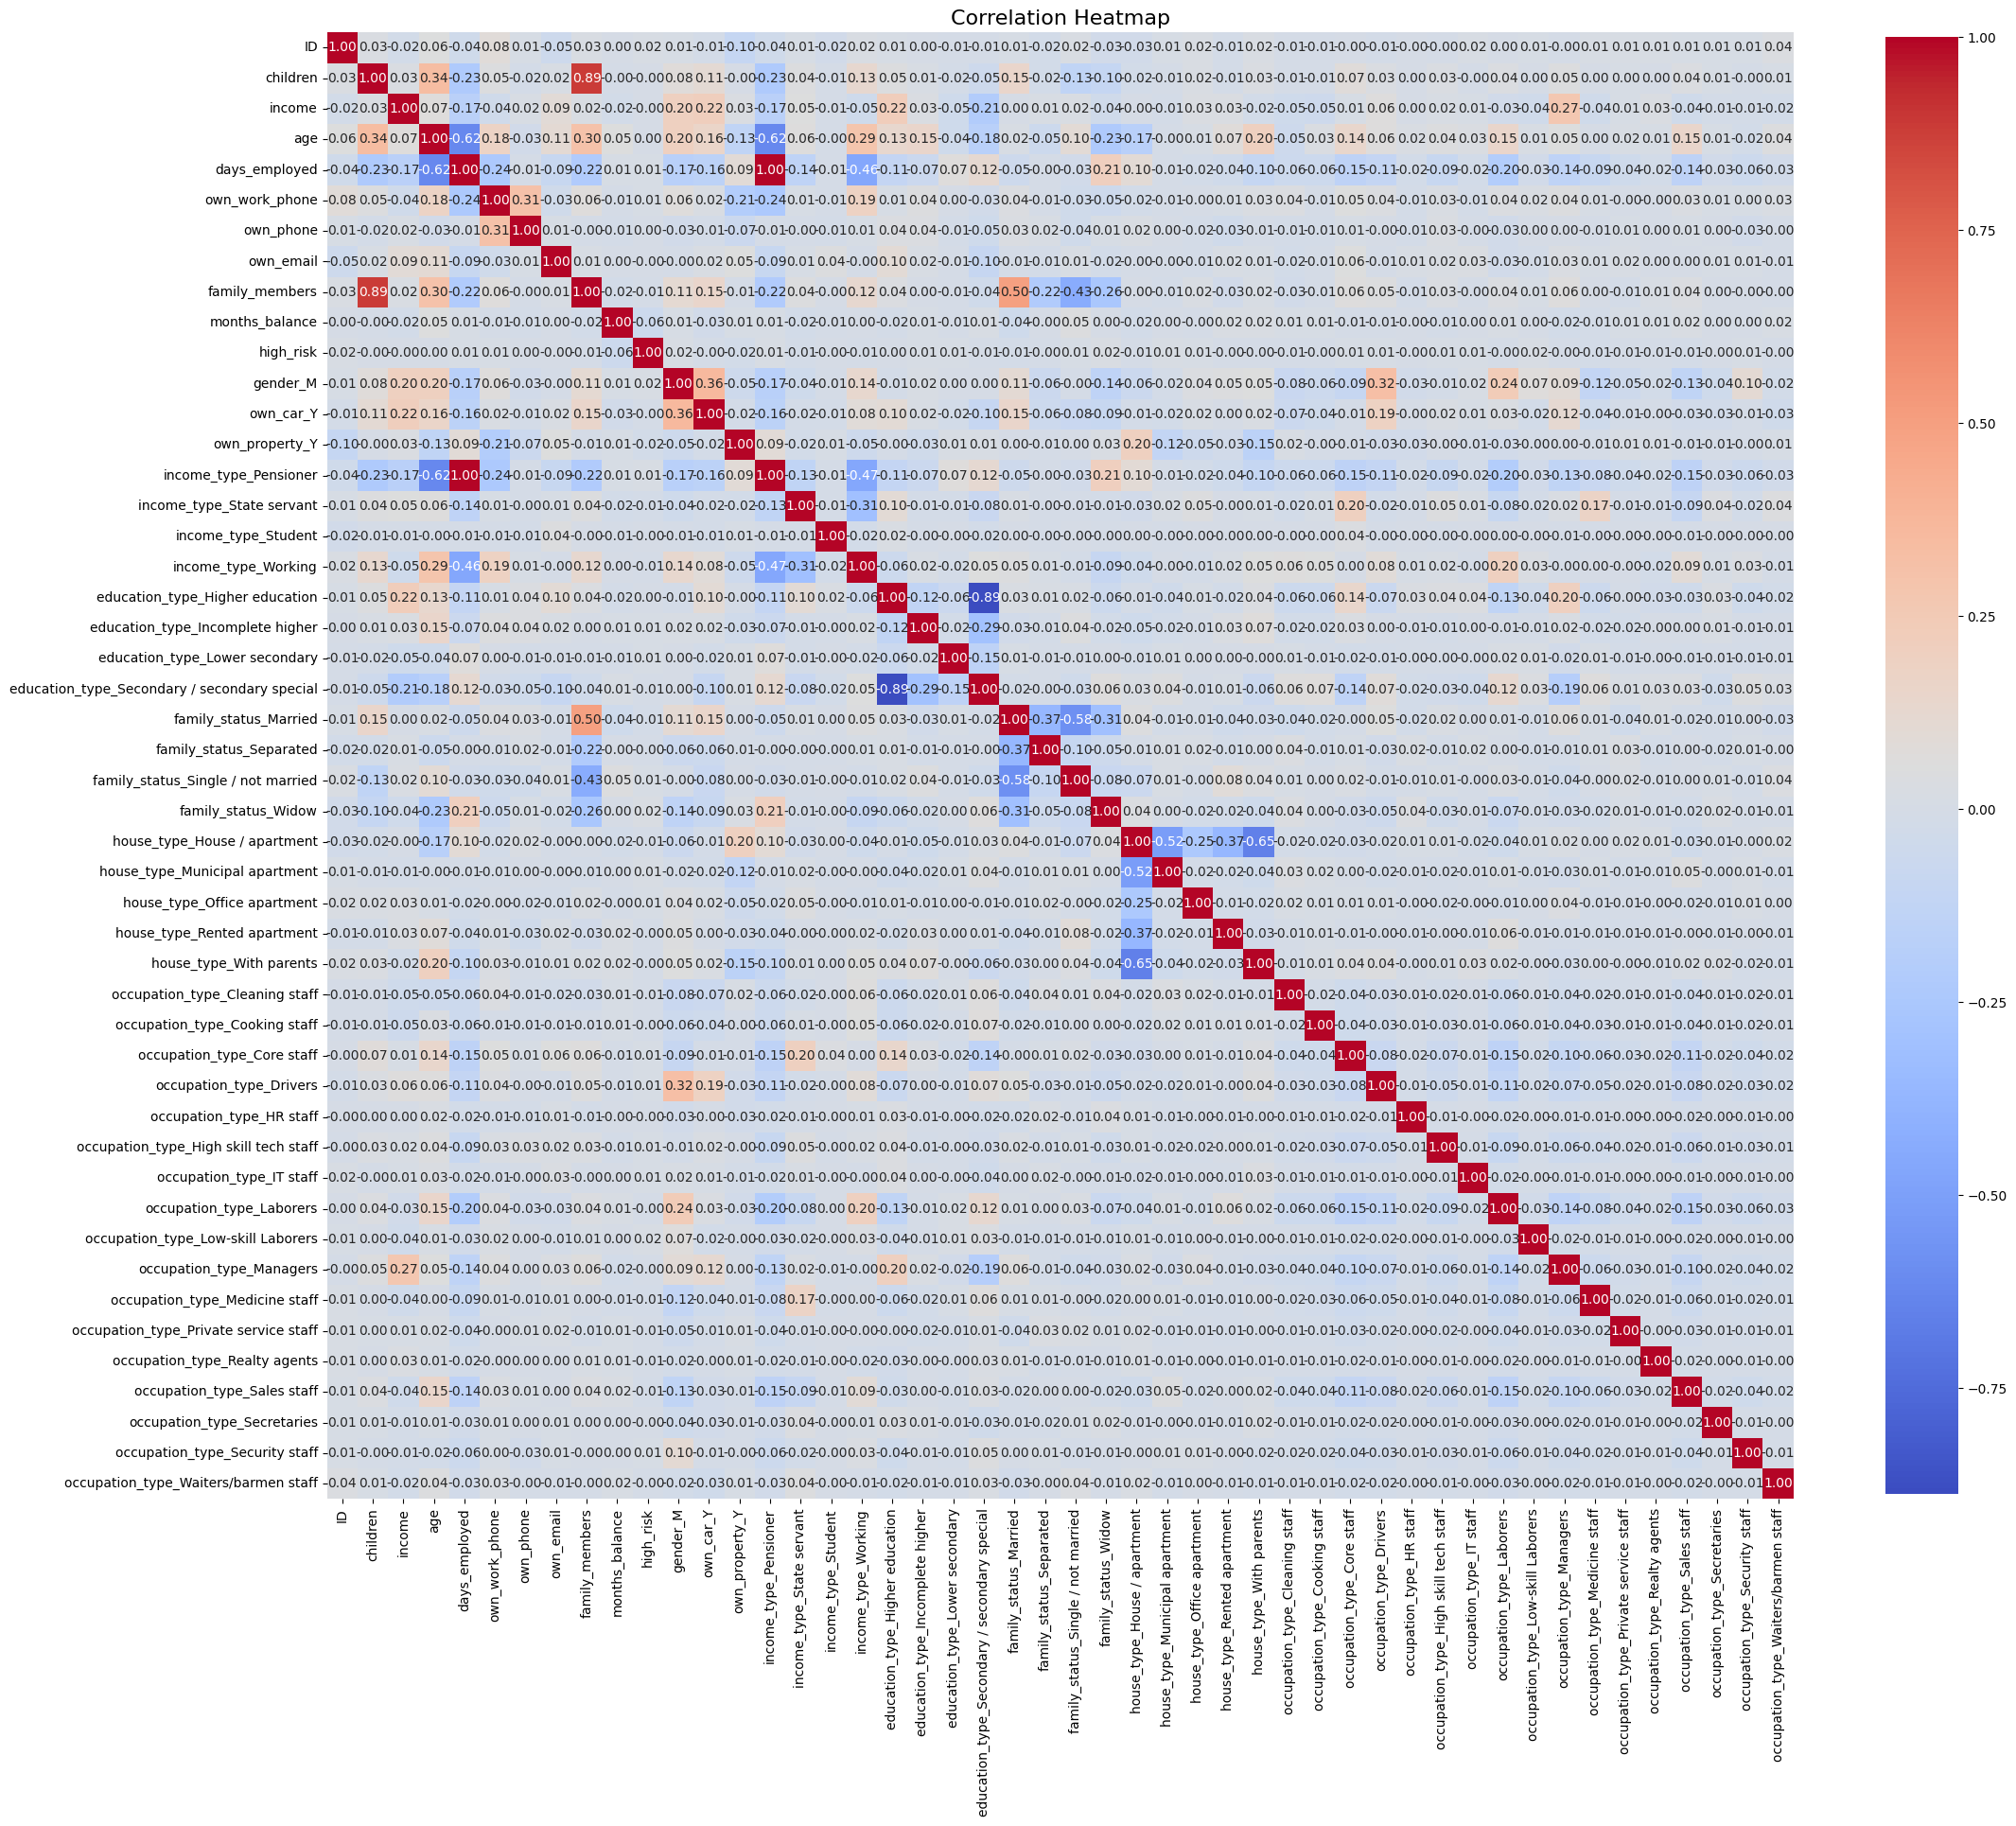

In [68]:
# Convert categorical variables to numerical using one-hot encoding
df_heatmap = pd.get_dummies(df_temp, drop_first = True)

df_heatmap.describe(include="all")
# Calculate the correlation heatmap
correlation_heatmap = df_heatmap.corr()

# Set up the matplotlib figure
plt.figure(figsize=(25, 25))

# Create a heatmap
sns.heatmap(correlation_heatmap, annot = True, fmt = ".2f", cmap = "coolwarm", square = True, cbar_kws = {"shrink": .8})

# Set the title
plt.title("Correlation Heatmap", fontsize = 16)

# Show the plot
plt.show()

In [69]:
# la variable own_mobile_phone al ser unica, tiene un espacio vacio, por lo que se eliminara al final

In [70]:
# no se ve que ninguna variable tenga relacion directa con nuestra variable target "high_risk"

In [71]:
# hay que corregir los pensionados que tienen days_employed con valor de 365243

In [72]:
# income_type_Pensioner relacionado con la edad (pensión a partir de cierta edad) o que el pensionado esta desempleado. 

In [73]:
# si esta casado es mas propenso a tener mas miembros familiares y la variable family_members esta muy relacionada con children

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   gender            36457 non-null  object 
 2   own_car           36457 non-null  object 
 3   own_property      36457 non-null  object 
 4   children          36457 non-null  int64  
 5   income            36457 non-null  float64
 6   income_type       36457 non-null  object 
 7   education_type    36457 non-null  object 
 8   family_status     36457 non-null  object 
 9   house_type        36457 non-null  object 
 10  age               36457 non-null  int64  
 11  days_employed     36457 non-null  int64  
 12  own_mobile_phone  36457 non-null  int64  
 13  own_work_phone    36457 non-null  int64  
 14  own_phone         36457 non-null  int64  
 15  own_email         36457 non-null  int64  
 16  occupation_type   25134 non-null  object

In [75]:
df.describe(include="all")

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
count,3.645700e+04,36457,36457,36457,36457.000000,3.645700e+04,36457,36457,36457,36457,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,25134,36457.000000,36457.000000,36457.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN
freq,NaN,24430,22614,24506,NaN,NaN,18819,24777,25048,32548,NaN,NaN,NaN,NaN,NaN,NaN,6211,NaN,NaN,NaN
mean,5.078227e+06,NaN,NaN,NaN,0.430315,1.866857e+05,NaN,NaN,NaN,NaN,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,NaN,2.198453,-26.164193,0.016897
std,4.187524e+04,NaN,NaN,NaN,0.742367,1.017892e+05,NaN,NaN,NaN,NaN,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,NaN,0.911686,16.501854,0.128886
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000,-60.000000,0.000000
25%,5.042028e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-39.000000,0.000000
50%,5.074614e+06,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-24.000000,0.000000
75%,5.115396e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000,-12.000000,0.000000


In [76]:
# comienzo a preparar el dataset para el entrenamiento del modelo

In [77]:
df_train_copy.shape

(29165, 20)

In [78]:
class Outliercapper(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=["family_members", "income", "days_employed"]):
        self.feat_with_outliers = feat_with_outliers
        self.bounds_ = {}  # Stores lower/upper bounds for each feature

    def fit(self, x, y=None):
        # Ensure features exist in the training data
        if not set(self.feat_with_outliers).issubset(x.columns):
            raise ValueError("One or more features are missing in the training data.")
        
        # Calculate and store IQR bounds for each feature
        for feature in self.feat_with_outliers:
            Q1 = x[feature].quantile(0.25)
            Q3 = x[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            self.bounds_[feature] = (lower_bound, upper_bound)
        return self

    def transform(self, x):
        X_transformed = x.copy()
        # Check if features exist in the new data
        if set(self.feat_with_outliers).issubset(X_transformed.columns):
            for feature in self.feat_with_outliers:
                lower, upper = self.bounds_[feature]
                # Cap values to the bounds
                X_transformed[feature] = X_transformed[feature].clip(lower=lower, upper=upper)
            return X_transformed
        else:
            print("Warning: One or more features missing. Returning original data.")
            return x

In [79]:
df_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7292 entries, 0 to 7291
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                7292 non-null   int64  
 1   gender            7292 non-null   object 
 2   own_car           7292 non-null   object 
 3   own_property      7292 non-null   object 
 4   children          7292 non-null   int64  
 5   income            7292 non-null   float64
 6   income_type       7292 non-null   object 
 7   education_type    7292 non-null   object 
 8   family_status     7292 non-null   object 
 9   house_type        7292 non-null   object 
 10  age               7292 non-null   int64  
 11  days_employed     7292 non-null   int64  
 12  own_mobile_phone  7292 non-null   int64  
 13  own_work_phone    7292 non-null   int64  
 14  own_phone         7292 non-null   int64  
 15  own_email         7292 non-null   int64  
 16  occupation_type   4996 non-null   object 


In [80]:
class Dropper(BaseEstimator,TransformerMixin):
    """Dropea las variables irrelevantes o inusables"""
    
    def __init__(self, columns_to_remove=("ID", "own_mobile_phone", "children", "occupation_type", "months_balance")):
        self.columns_to_remove = list(columns_to_remove)

    def fit(self, data):
        return self
    
    def transform(self, data):
        column_check = all(col in data.columns for col in self.columns_to_remove)
        if column_check:
            data.drop(columns = self.columns_to_remove, inplace = True)
        else:
            print("One or more features are not in the dataframe")
        return data

In [81]:
class TimeConverter(BaseEstimator, TransformerMixin):
    """Convierte variables de tiempo a valores absolutos"""
    
    def __init__(self, days = ["days_employed", "age"]):
        self.days = days

    def fit(self, x):
        return self
    
    def transform(self, x):
        required_columns = set(self.days)
        if required_columns.issubset(x.columns):
            # paso a absoluto
            x[list(required_columns)] = np.abs(x[list(required_columns)])
        else:
            print("One or more features are not in the dataframe")
        return x

In [82]:
class Retirees(BaseEstimator, TransformerMixin):
    """ Identifica a las personas retiradas y resetea la variable days_employed para mayor claridad"""
    def __init__(self):
        pass

    def fit(self, x):
        return self
    
    def transform(self, x):
        if "days_employed" in x.columns:
            retire_mask = x["days_employed"] == 365243
            x.loc[retire_mask, "days_employed"] = 0
        else:
            print("days_employed is not in the dataframe")
        return x

In [83]:
class Skewness(BaseEstimator, TransformerMixin):
    """ Reduce la asimetria en la distribución de variables dadas usando la transformación de raiz cúbica """

    def __init__(self,skewness=["income", "age"]):
        self.skewness = skewness

    def fit(self, data):
        return self
    
    def transform(self, data):
        required_features = set(self.skewness)
        if required_features.issubset(data.columns):
            # aplico raiz cubica
            data[list(required_features)] = np.cbrt(data[list(required_features)])
        else:
            print("One or more features are not in the dataframe")
        return data

In [84]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    """ Convierte binarios en Y/N """

    def __init__(self, num_encoding=["own_work_phone","own_phone","own_email"]):
        self.num_encoding = num_encoding

    def fit(self, data):
        return self
    
    def transform(self, data):
        required_features = set(self.num_encoding)
        if required_features.issubset(data.columns):
            for feature in self.num_encoding:
                data[feature] = data[feature].map({1:"Y",0:"N"})
        else:
            print("One or more features are not in the dataframe")
        return data

In [85]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    """ Aplica one-hot encoding  """

    def __init__(self, one_hot_encoding=None):
        if one_hot_encoding is None:
            one_hot_encoding = ["gender", "family_status", "house_type", "income_type", "own_car", "own_property", "own_work_phone", "own_phone", "own_email"]
        self.one_hot_encoding = one_hot_encoding

    def fit(self, data):
        return self

    def transform(self, data):
        required_features = set(self.one_hot_encoding)
        if not required_features.issubset(data.columns):
            print("One or more features are not in the dataframe")
            return data
        encoded_features = pd.get_dummies(data[self.one_hot_encoding])
        remaining_features = data.drop(columns = self.one_hot_encoding)
        
        return pd.concat([encoded_features, remaining_features], axis=1)

In [86]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    """ Aplica ordinal encoding """

    def __init__(self, or_encode_feat = ["education_type"]):
        self.or_encode_feat = or_encode_feat

    def fit(self, data):
        return self
    
    def transform(self, data):
        if "education_type" in data.columns:
            ordinal_encoding = OrdinalEncoder()
            data[self.or_encode_feat] = ordinal_encoding.fit_transform(data[self.or_encode_feat])
            return data
        print("education_type is not in the dataframe")
        return data

In [87]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    """ Normaliza los datos aplicando min-max scaling para variables numericas """
    
    def __init__(self, min_max_features = ["age", "income", "days_employed"]):
        self.min_max_features = min_max_features

    def fit(self, data): 
        return self
    
    def transform(self, data):
        required_features = set(self.min_max_features)
        if not required_features.issubset(data.columns):
            print("One or more features are not in the dataframe")
            return data
        scaler = MinMaxScaler()
        data[self.min_max_features] = scaler.fit_transform(data[self.min_max_features])
        return data

In [88]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    """ Convierte la variable target en una variable numerica """

    def __init__(self):
        pass
    
    def fit(self, data):
        return self
    
    def transform(self, data):
        if "high_risk" in data.columns:
            data["high_risk"] = pd.to_numeric(data["high_risk"])
            return data
        print("high_risk is not in the dataframe")
        return data

In [89]:
# ahora tengo que balancear los datos con el metodo SMOTE 

class Oversample(BaseEstimator, TransformerMixin):
    """Custom transformer to address class imbalance using SMOTE oversampling."""
    
    def __init__(self) -> None:
        """Initialize SMOTE oversampling transformer."""
        pass  # Explicit empty constructor for clarity

    def fit(self, df: pd.DataFrame, y: any = None) -> 'Oversample':
        """Fit method (no actual fitting needed, returns self)."""
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        if "high_risk" in df.columns:
            oversample = SMOTE(sampling_strategy="minority")
            x_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != "high_risk"], df["high_risk"])
            df_bal = pd.concat([pd.DataFrame(x_bal), pd.DataFrame(y_bal)], axis=1)
            return df_bal
        else:
            print("high_risk is not in the dataframe")
            return df


In [90]:
df

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,1


In [91]:
# creo una unica funcion pipeline para llamar todas las clases

In [92]:
def all_pipeline(df):
    pipeline = Pipeline([
        ("outlier_capper", Outliercapper()),
        ("feature_dropper", Dropper()),
        ("time_conversion_handler", TimeConverter()),
        ("retiree_handler", Retirees()),
        ("skewness_handler", Skewness()),
        ("binning_num_to_yn", BinningNumToYN()),
        ("one_hot_with_feat_names", OneHotWithFeatNames()),
        ("ordinal_feat_names", OrdinalFeatNames()),
        ("min_max_with_feat_names", MinMaxWithFeatNames()),
        ("change_to_num_target", ChangeToNumTarget()),
        ("oversample", Oversample())
    ])
    df_prep = pipeline.fit_transform(df)
    return df_prep

In [93]:
# aplico secuencialmente las clases del preprocessing a un dataframe temporal para debuggear mas facil la shape del dataset en cada paso

In [94]:
df_temp = df_original.copy()

steps = [
    ("Dropper", Dropper()),
    ("TimeConverter", TimeConverter()),
    ("Retirees", Retirees()),
    ("Skewness", Skewness()),
    ("BinningNumToYN", BinningNumToYN()),
    ("OneHotWithFeatNames", OneHotWithFeatNames()),
    ("OrdinalFeatNames", OrdinalFeatNames()),
    ("MinMaxWithFeatNames", MinMaxWithFeatNames()),
    ("ChangeToNumTarget", ChangeToNumTarget()),
    ("Oversample", Oversample())
]

for name, step in steps:
    df_temp = step.fit_transform(df_temp)
    print(f"After {name}: {df_temp.shape}")

After Dropper: (36457, 15)
After TimeConverter: (36457, 15)
After Retirees: (36457, 15)
After Skewness: (36457, 15)
After BinningNumToYN: (36457, 15)
After OneHotWithFeatNames: (36457, 34)
After OrdinalFeatNames: (36457, 34)
After MinMaxWithFeatNames: (36457, 34)
After ChangeToNumTarget: (36457, 34)
After Oversample: (71682, 34)


In [95]:
train_prep = all_pipeline(df_train_copy)

In [96]:
train_prep.shape


(57332, 34)

In [97]:
train_prep

,gender_F,gender_M,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,...,own_phone_N,own_phone_Y,own_email_N,own_email_Y,income,education_type,age,days_employed,family_members,high_risk
0,False,True,False,True,False,False,False,False,False,False,...,True,False,True,False,0.415955,4.0,0.585324,0.272383,2.000000,0
1,True,False,False,False,False,True,False,False,True,False,...,True,False,True,False,0.415955,1.0,0.197547,0.143851,2.000000,0
2,True,False,False,True,False,False,False,False,True,False,...,True,False,True,False,0.516782,4.0,0.382672,0.496523,4.000000,0
3,True,False,False,False,False,True,False,False,True,False,...,True,False,False,True,0.803385,1.0,0.817641,0.178625,1.000000,0
4,True,False,False,False,True,False,False,False,True,False,...,False,True,True,False,0.676351,4.0,0.581840,0.043842,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57327,False,True,False,True,False,True,False,False,True,False,...,True,False,True,False,0.676351,4.0,0.618878,0.020336,2.000000,1
57328,True,False,True,False,False,False,False,False,True,False,...,True,True,True,False,0.422100,4.0,0.466652,0.264905,2.000000,1
57329,False,True,True,True,False,False,False,False,True,False,...,True,False,True,False,0.445831,4.0,0.380931,0.187780,2.814063,1
57330,False,True,False,True,False,False,False,False,True,False,...,False,True,True,True,0.816053,1.0,0.257628,0.040135,3.000000,1


In [98]:
x = train_prep.drop(columns="high_risk")
y = train_prep["high_risk"].astype("int64")

In [99]:
x

,gender_F,gender_M,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,...,own_work_phone_Y,own_phone_N,own_phone_Y,own_email_N,own_email_Y,income,education_type,age,days_employed,family_members
0,False,True,False,True,False,False,False,False,False,False,...,False,True,False,True,False,0.415955,4.0,0.585324,0.272383,2.000000
1,True,False,False,False,False,True,False,False,True,False,...,False,True,False,True,False,0.415955,1.0,0.197547,0.143851,2.000000
2,True,False,False,True,False,False,False,False,True,False,...,False,True,False,True,False,0.516782,4.0,0.382672,0.496523,4.000000
3,True,False,False,False,False,True,False,False,True,False,...,False,True,False,False,True,0.803385,1.0,0.817641,0.178625,1.000000
4,True,False,False,False,True,False,False,False,True,False,...,False,False,True,True,False,0.676351,4.0,0.581840,0.043842,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57327,False,True,False,True,False,True,False,False,True,False,...,False,True,False,True,False,0.676351,4.0,0.618878,0.020336,2.000000
57328,True,False,True,False,False,False,False,False,True,False,...,False,True,True,True,False,0.422100,4.0,0.466652,0.264905,2.000000
57329,False,True,True,True,False,False,False,False,True,False,...,False,True,False,True,False,0.445831,4.0,0.380931,0.187780,2.814063
57330,False,True,False,True,False,False,False,False,True,False,...,True,False,True,True,True,0.816053,1.0,0.257628,0.040135,3.000000


In [100]:
y

0        0
1        0
2        0
3        0
4        0
        ..
57327    1
57328    1
57329    1
57330    1
57331    1
Name: high_risk, Length: 57332, dtype: int64

In [101]:
df

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,1


In [102]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      8593
           1       0.98      0.61      0.75      8607

    accuracy                           0.80     17200
   macro avg       0.85      0.80      0.79     17200
weighted avg       0.85      0.80      0.79     17200

Logistic Regression Classifier AUC-ROC: 0.86


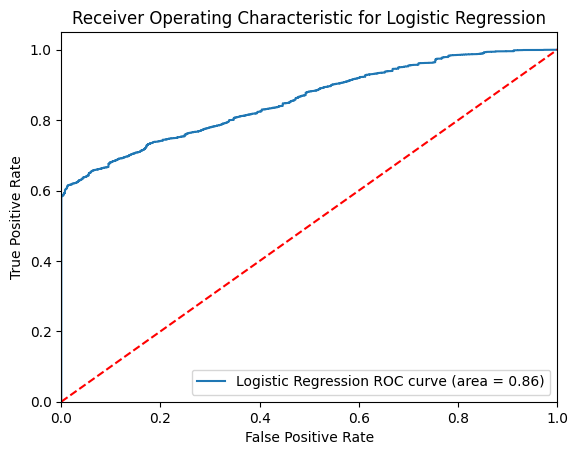

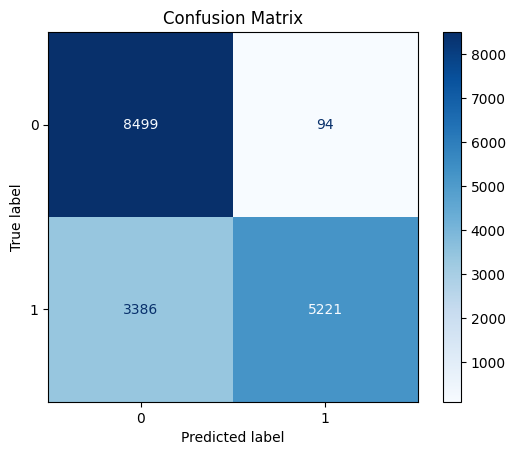

In [103]:
# 1- Training
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(x_train, y_train)

# 2- Predictions
pred_logreg = logreg_model.predict(x_test)  # Get predicted class labels
pred_logreg_proba = logreg_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, pred_logreg))

# 4- ROC-AUC Score
roc_auc_lr = roc_auc_score(y_test, pred_logreg_proba)
print(f"Logistic Regression Classifier AUC-ROC: {roc_auc_lr:.2f}")

# 5- ROC Curve
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, pred_logreg_proba)
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression ROC curve (area = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm = confusion_matrix(y_test, pred_logreg)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.84      0.70      8593
           1       0.73      0.42      0.53      8607

    accuracy                           0.63     17200
   macro avg       0.66      0.63      0.62     17200
weighted avg       0.66      0.63      0.62     17200

Random Forest AUC-ROC: 0.69


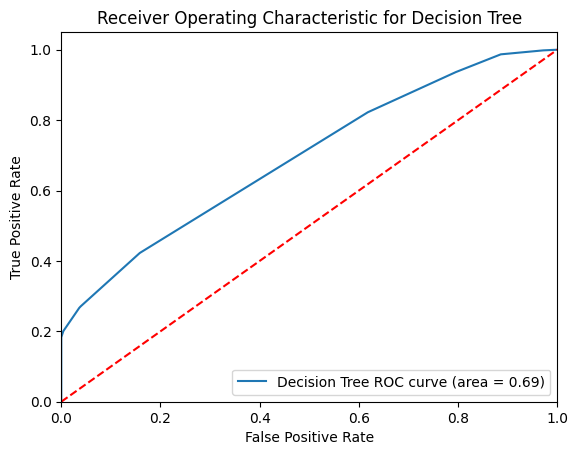

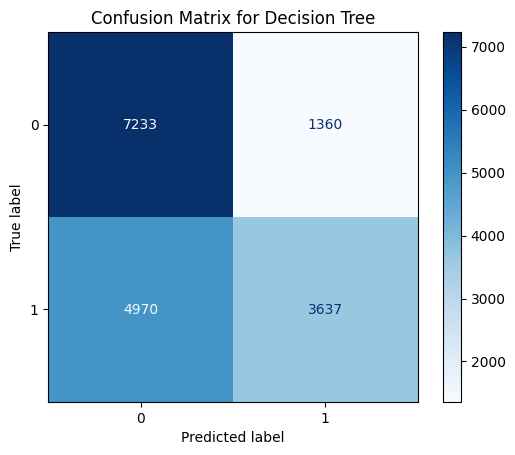

In [104]:
# 1- Training
dt_model = DecisionTreeClassifier(max_depth=4)
dt_model.fit(x_train, y_train)

# 2- Predictions
pred_dt = dt_model.predict(x_test)  # Get predicted class labels
pred_dt_proba = dt_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("Decision Tree Classification Report:")
print(classification_report(y_test, pred_dt))

# 4- ROC-AUC Score
roc_auc_dt = roc_auc_score(y_test, dt_model.predict_proba(x_test)[:, 1])
print(f"Random Forest AUC-ROC: {roc_auc_dt:.2f}")

# 5- ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, pred_dt_proba)
plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree ROC curve (area = {roc_auc_dt:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Decision Tree")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm = confusion_matrix(y_test, pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Decision Tree")
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8593
           1       0.99      0.99      0.99      8607

    accuracy                           0.99     17200
   macro avg       0.99      0.99      0.99     17200
weighted avg       0.99      0.99      0.99     17200

Random Forest AUC-ROC: 1.00


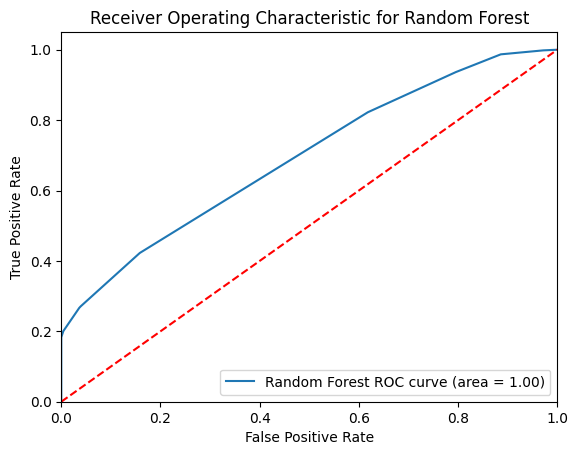

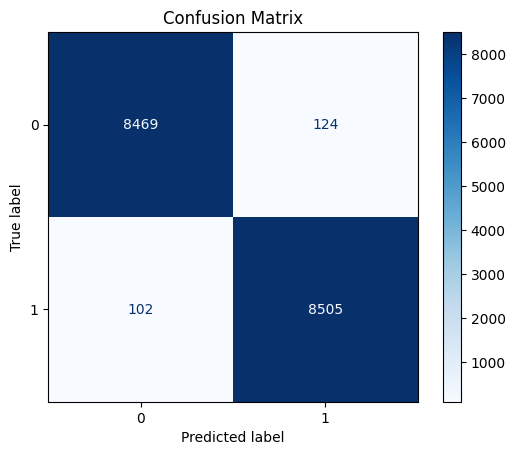

In [105]:
# 1- Training
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

# 2- Predictions
pred_rf = rf_model.predict(x_test)  # Get predicted class labels
pred_rf_proba = rf_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, pred_rf))

# 4- ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, pred_rf_proba)
print(f"Random Forest AUC-ROC: {roc_auc_rf:.2f}")

# 5- ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf_proba)
plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f"Random Forest ROC curve (area = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Random Forest")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm = confusion_matrix(y_test, pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      8593
           1       0.94      0.79      0.86      8607

    accuracy                           0.87     17200
   macro avg       0.88      0.87      0.87     17200
weighted avg       0.88      0.87      0.87     17200

SVM AUC-ROC: 0.95


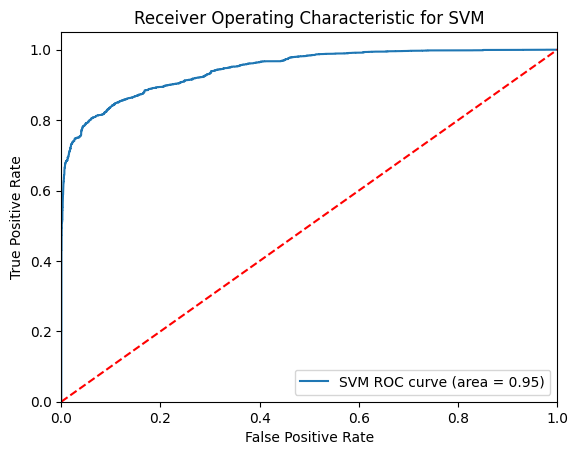

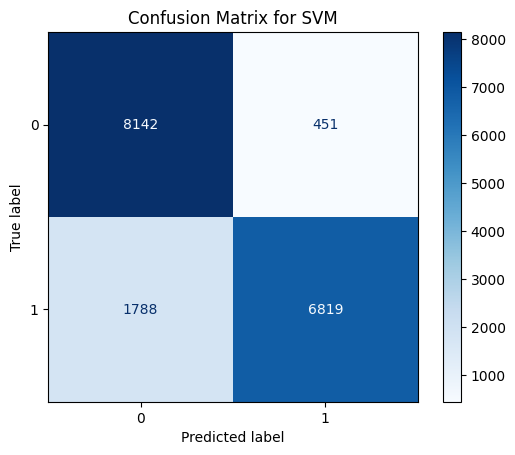

In [106]:
# 1- Training
svm_model = SVC(probability=True, random_state=42)  # Set probability=True to use predict_proba
svm_model.fit(x_train, y_train)

# 2- Predictions
pred_svm = svm_model.predict(x_test)
pred_svm_proba = svm_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("SVM Classification Report:")
print(classification_report(y_test, pred_svm))

# 4- ROC-AUC Score
roc_auc_svm = roc_auc_score(y_test, pred_svm_proba)
print(f"SVM AUC-ROC: {roc_auc_svm:.2f}")

# 5- ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, pred_svm_proba)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f"SVM ROC curve (area = {roc_auc_svm:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for SVM")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_svm = confusion_matrix(y_test, pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM")
plt.show()

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      8593
           1       0.90      0.86      0.88      8607

    accuracy                           0.88     17200
   macro avg       0.88      0.88      0.88     17200
weighted avg       0.88      0.88      0.88     17200

Gradient Boosting AUC-ROC: 0.96


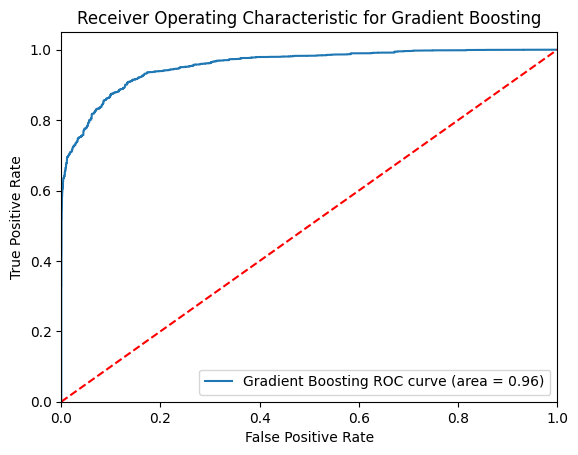

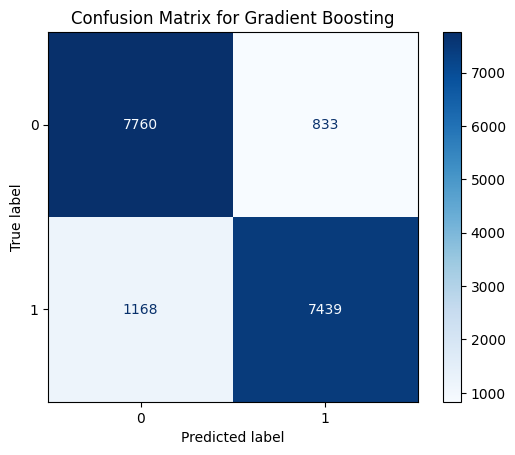

In [107]:
# 1- Training
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(x_train, y_train)

# 2- Predictions
pred_gb = gb_model.predict(x_test)
pred_gb_proba = gb_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, pred_gb))

# 4- ROC-AUC Score
roc_auc_gb = roc_auc_score(y_test, pred_gb_proba)
print(f"Gradient Boosting AUC-ROC: {roc_auc_gb:.2f}")

# 5- ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, pred_gb_proba)
plt.figure()
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting ROC curve (area = {roc_auc_gb:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Gradient Boosting")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_gb = confusion_matrix(y_test, pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=gb_model.classes_)
disp_gb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8593
           1       0.98      0.98      0.98      8607

    accuracy                           0.98     17200
   macro avg       0.98      0.98      0.98     17200
weighted avg       0.98      0.98      0.98     17200

XGB AUC-ROC: 1.00


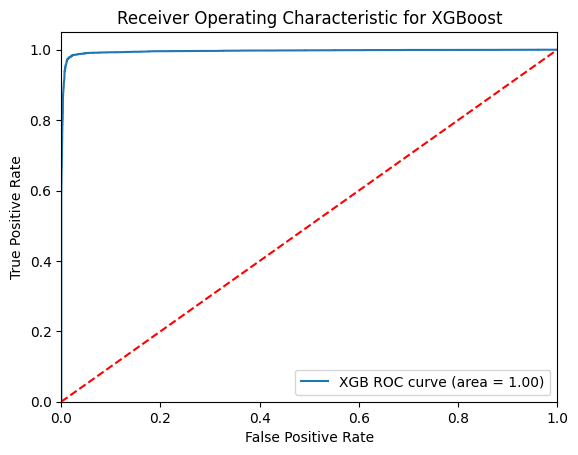

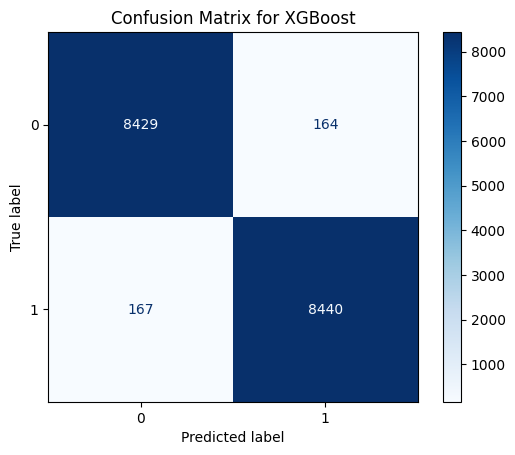

In [108]:
# 1- Training
xgb_model = xgb.XGBClassifier(eval_metric="logloss" ,random_state=42)
xgb_model.fit(x_train, y_train)

# 2- Predictions
pred_xgb = xgb_model.predict(x_test)
pred_xgb_proba = xgb_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("XGBoost Classification Report:")
print(classification_report(y_test, pred_xgb))

# 4- ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, pred_xgb_proba)
print(f"XGB AUC-ROC: {roc_auc_xgb:.2f}")

# 5- ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, pred_xgb_proba)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB ROC curve (area = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for XGBoost")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_xgb = confusion_matrix(y_test, pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_model.classes_)
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost")
plt.show()

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8593
           1       0.96      0.98      0.97      8607

    accuracy                           0.97     17200
   macro avg       0.97      0.97      0.97     17200
weighted avg       0.97      0.97      0.97     17200

KNN AUC-ROC: 0.99


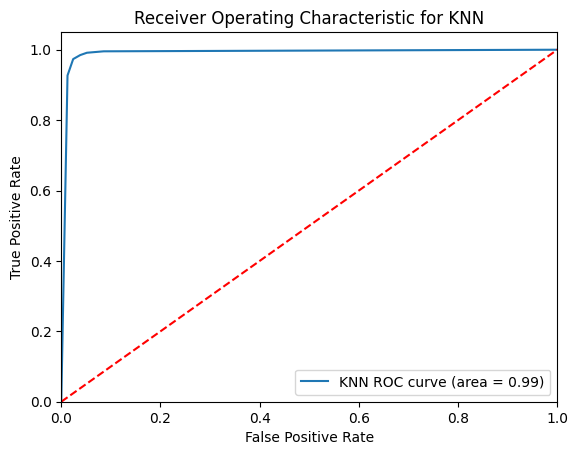

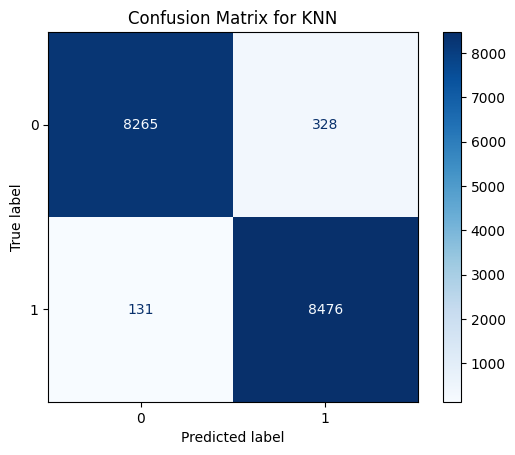

In [109]:
# 1- Training
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train, y_train)

# 2- Predictions
pred_knn = knn_model.predict(x_test)
pred_knn_proba = knn_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("KNN Classification Report:")
print(classification_report(y_test, pred_knn))

# 4- ROC-AUC Score
roc_auc_knn = roc_auc_score(y_test, pred_knn_proba)
print(f"KNN AUC-ROC: {roc_auc_knn:.2f}")

# 5- ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, pred_knn_proba)
plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f"KNN ROC curve (area = {roc_auc_knn:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for KNN")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_knn = confusion_matrix(y_test, pred_knn)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn_model.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN")
plt.show()

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      8593
           1       0.64      0.65      0.64      8607

    accuracy                           0.64     17200
   macro avg       0.64      0.64      0.64     17200
weighted avg       0.64      0.64      0.64     17200

AdaBoost AUC-ROC: 0.69


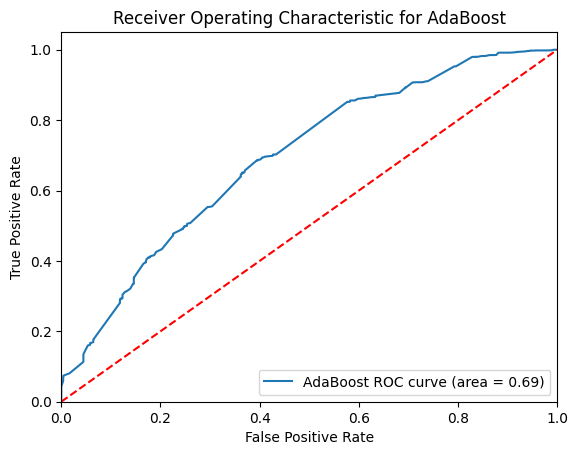

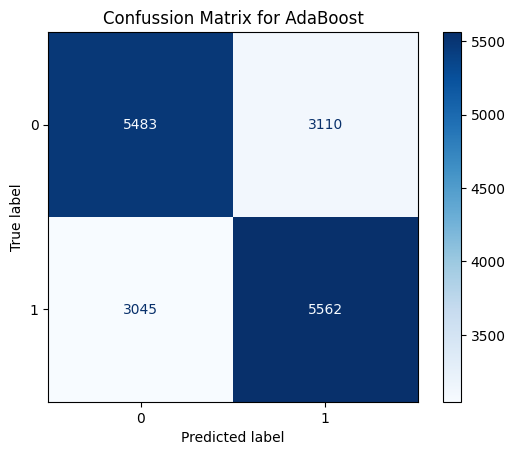

In [110]:
# 1- Training
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(x_train, y_train)

# 2- Predictions
pred_ada = ada_model.predict(x_test)
pred_ada_proba = ada_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("AdaBoost Classification Report:")
print(classification_report(y_test, pred_ada))

# 4- ROC-AUC Score
roc_auc_ada = roc_auc_score(y_test, pred_ada_proba)
print(f"AdaBoost AUC-ROC: {roc_auc_ada:.2f}")

# 5- ROC Curve
fpr_ada, tpr_ada, _ = roc_curve(y_test, pred_ada_proba)
plt.figure()
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost ROC curve (area = {roc_auc_ada:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for AdaBoost")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_ada = confusion_matrix(y_test, pred_ada)
disp_ada = ConfusionMatrixDisplay(confusion_matrix= cm_ada, display_labels=ada_model.classes_)
disp_ada.plot(cmap=plt.cm.Blues)
plt.title("Confussion Matrix for AdaBoost")
plt.show()

Classification Report of Naive Bayes
              precision    recall  f1-score   support

           0       0.70      0.08      0.15      8593
           1       0.51      0.96      0.67      8607

    accuracy                           0.52     17200
   macro avg       0.61      0.52      0.41     17200
weighted avg       0.61      0.52      0.41     17200

Naive Bayes AUC-ROC: 0.64


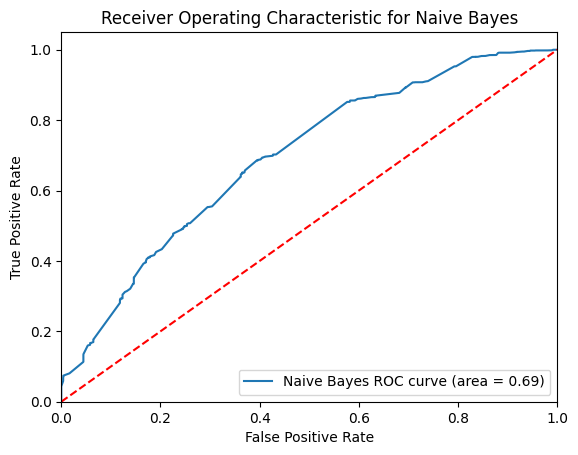

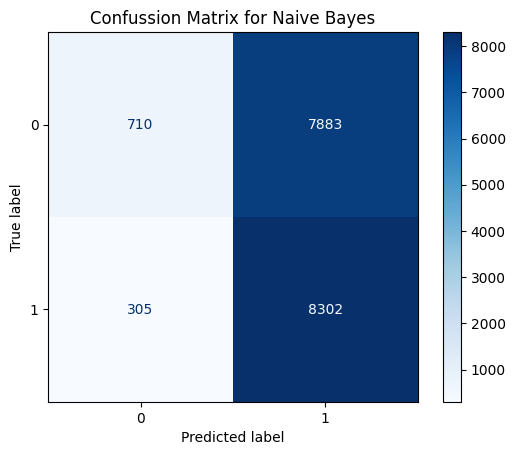

In [111]:
# 1- Training
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)

# 2- Predictions
pred_gnb = gnb_model.predict(x_test)
pred_gnb_proba = gnb_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("Classification Report of Naive Bayes")
print(classification_report(y_test, pred_gnb))

# 4- ROC-AUC Score
roc_auc_gnb = roc_auc_score(y_test, pred_gnb_proba)
print(f"Naive Bayes AUC-ROC: {roc_auc_gnb:.2f}")

# 5- ROC Curve
fpr_ada, tpr_ada, _ = roc_curve(y_test, pred_ada_proba)
plt.figure()
plt.plot(fpr_ada, tpr_ada, label=f"Naive Bayes ROC curve (area = {roc_auc_ada:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Naive Bayes")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_gnb = confusion_matrix(y_test, pred_gnb)
disp_gnb = ConfusionMatrixDisplay(confusion_matrix= cm_gnb, display_labels=gnb_model.classes_)
disp_gnb.plot(cmap=plt.cm.Blues)
plt.title("Confussion Matrix for Naive Bayes")
plt.show()

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8593
           1       0.96      0.94      0.95      8607

    accuracy                           0.95     17200
   macro avg       0.95      0.95      0.95     17200
weighted avg       0.95      0.95      0.95     17200

Neural Network AUC-ROC: 0.99


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


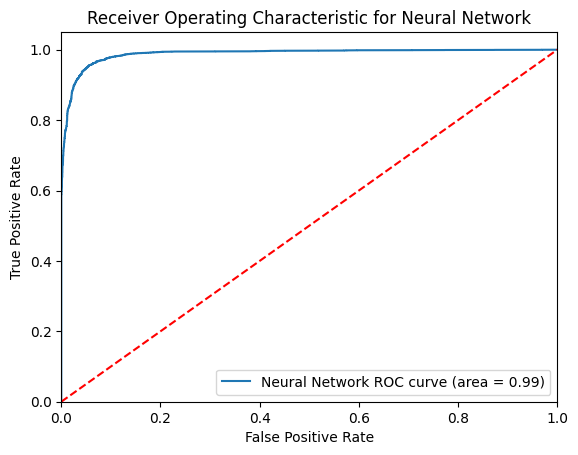

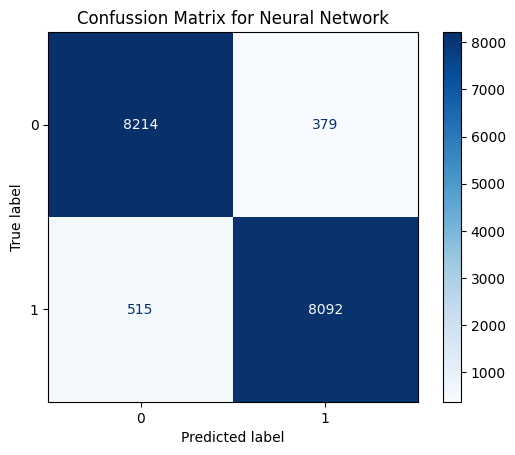

In [112]:
# 1- Training
mlp_model = MLPClassifier(random_state=42)
mlp_model.fit(x_train, y_train)

# 2- Predictions
pred_mlp = mlp_model.predict(x_test)
pred_mlp_proba = mlp_model.predict_proba(x_test)[:, 1]

# 3- Classification Report
print("Neural Network Classification Report:")
print(classification_report(y_test, pred_mlp))

# 4- ROC-AUC Score
roc_auc_mlp = roc_auc_score(y_test, pred_mlp_proba)
print(f"Neural Network AUC-ROC: {roc_auc_mlp:.2f}")

# 5- ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_mlp_proba)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f"Neural Network ROC curve (area = {roc_auc_mlp:.2f})")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Neural Network")
plt.legend(loc="lower right")
plt.show()

# 6- Confusion Matrix
cm_mlp = confusion_matrix(y_test, pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix= cm_mlp, display_labels=mlp_model.classes_)
disp_mlp.plot(cmap=plt.cm.Blues)
plt.title("Confussion Matrix for Neural Network")
plt.show()

In [113]:
# the best overall model is Gradient Boosting, observing the metrics such as recall, precision and f1 score, we could say that it is the most suitable, 
# it is not overfitting as others who fit perfectly in the dataset and its not poor enough to give some lowly confident predictions  

In [114]:
def all_pipeline(df):
    #Create the pipeline that will call all the class from OutlierRemoval to Oversample SMOTE in one go
    pipeline = Pipeline([
        ("outlier_capper", Outliercapper()),
        ("feature_dropper", Dropper()),
        ("time_conversion_handler", TimeConverter()),
        ("retiree_handler", Retirees()),
        ("skewness_handler", Skewness()),
        ("binning_num_to_yn", BinningNumToYN()),
        ("one_hot_with_feat_names", OneHotWithFeatNames()),
        ("ordinal_feat_names", OrdinalFeatNames()),
        ("min_max_with_feat_names", MinMaxWithFeatNames()),
        ("change_to_num_target", ChangeToNumTarget()),
        ("oversample", Oversample())
    ])
    df_prep = pipeline.fit_transform(df)
    return df_prep

In [115]:
x_test, y_test = train_prep.loc[:, train_prep.columns != "high_risk"], train_prep["high_risk"].astype("int64")

In [116]:
# training

In [117]:
x_train.columns

Index(['gender_F', 'gender_M', 'family_status_Civil marriage',
       'family_status_Married', 'family_status_Separated',
       'family_status_Single / not married', 'family_status_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'own_car_N', 'own_car_Y', 'own_property_N',
       'own_property_Y', 'own_work_phone_N', 'own_work_phone_Y', 'own_phone_N',
       'own_phone_Y', 'own_email_N', 'own_email_Y', 'income', 'education_type',
       'age', 'days_employed', 'family_members'],
      dtype='object')

In [118]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [119]:
pred_gb.shape

(17200,)

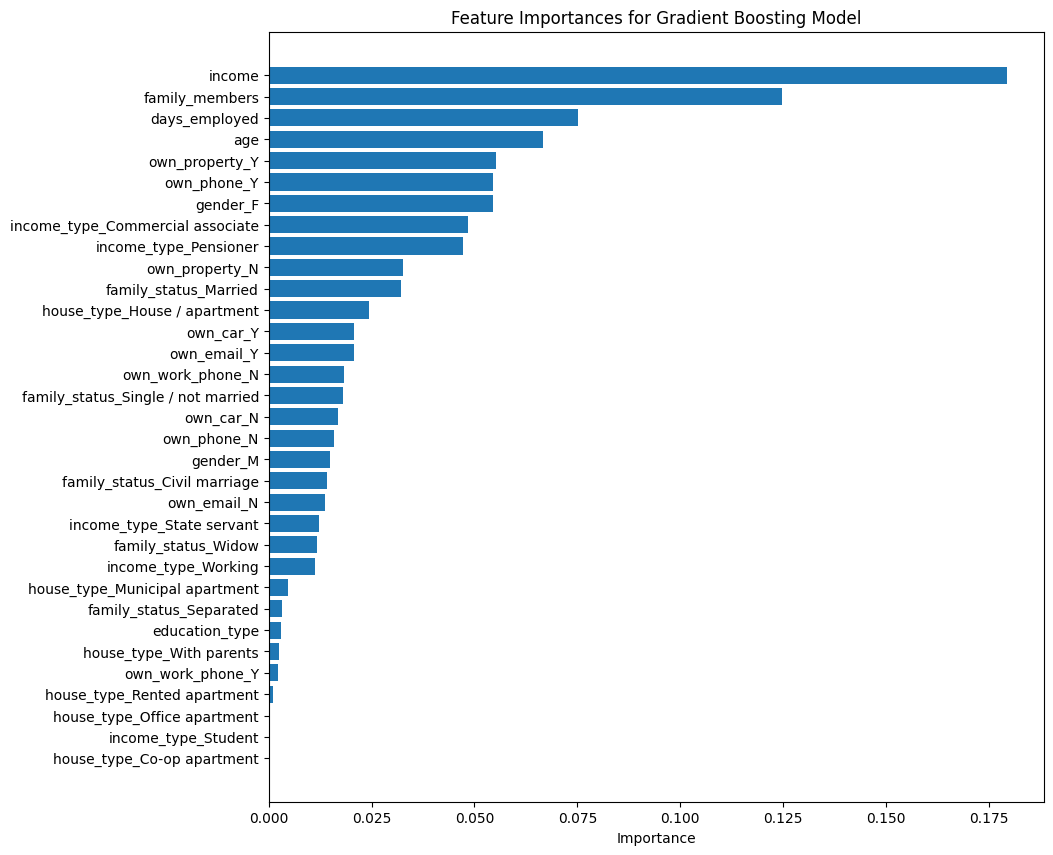

In [120]:
# Obtengo la importancia de cada Feature
feature_importances = gb_model.feature_importances_

# Creo un dataframe para mejor visualización
features = pd.DataFrame({"Feature": x_train.columns, "Importance": feature_importances})
features = features.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(features["Feature"], features["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importances for Gradient Boosting Model")
plt.show()

In [121]:
# predictions

In [122]:
final_prediction = gb_model.predict(x_test)


In [123]:
final_prediction.shape

(57332,)

In [124]:
final_prediction

array([0, 0, 0, ..., 1, 1, 0], shape=(57332,))

In [125]:
# creo dataframe con las predicciones

In [126]:
predictions_df = pd.DataFrame(final_prediction, columns=["Predicted"])

In [127]:
probability = sum(final_prediction == y_test)

In [128]:
print(probability/len(final_prediction))

0.884689178818112


In [129]:
df_original.shape

(36457, 20)

In [130]:
x.shape

(57332, 33)

In [131]:
# debugging

In [132]:
df_temp = df_original.copy()

steps = [
    ("outlier_capper", Outliercapper()),
    ("dropper", Dropper()),
    ("timeconverter", TimeConverter()),
    ("retirees", Retirees()),
    ("skewness", Skewness()),
    ("binning_num_to_yn", BinningNumToYN()),
    ("one_hot_with_feat_names", OneHotWithFeatNames()),
    ("ordinal_feat_names", OrdinalFeatNames()),
    ("min_max_with_feat_names", MinMaxWithFeatNames()),
    ("change_to_num_target", ChangeToNumTarget()),
]

for name, step in steps:
    df_temp = step.fit_transform(df_temp)
    print(f"After {name}: {df_temp.shape}")

After outlier_capper: (36457, 20)
After dropper: (36457, 15)
After timeconverter: (36457, 15)
After retirees: (36457, 15)
After skewness: (36457, 15)
After binning_num_to_yn: (36457, 15)
After one_hot_with_feat_names: (36457, 34)
After ordinal_feat_names: (36457, 34)
After min_max_with_feat_names: (36457, 34)
After change_to_num_target: (36457, 34)


In [133]:
# evito hacer el oversample para que la cantidad de datos corresponda con el dataset original y no haya problemas de merging

In [134]:
def pre_pipeline(df):
    pre_pipeline = Pipeline([
        ("outlier_capper", Outliercapper()),
        ("dropper", Dropper()),
        ("time_converter", TimeConverter()),
        ("retirees", Retirees()),
        ("skewness", Skewness()),
        ("binning_num_to_yn", BinningNumToYN()),
        ("one_hot_with_feat_names", OneHotWithFeatNames()),
        ("ordinal_feat_names", OrdinalFeatNames()),
        ("min_max_with_feat_names", MinMaxWithFeatNames()),
        ("change_to_num_target", ChangeToNumTarget())
    ])
    df_prep = pre_pipeline.fit_transform(df)
    return df_prep

In [135]:
df_cleared = pre_pipeline(df_original)

In [136]:
df_cleared.shape

(36457, 34)

In [137]:
x.columns

Index(['gender_F', 'gender_M', 'family_status_Civil marriage',
       'family_status_Married', 'family_status_Separated',
       'family_status_Single / not married', 'family_status_Widow',
       'house_type_Co-op apartment', 'house_type_House / apartment',
       'house_type_Municipal apartment', 'house_type_Office apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'own_car_N', 'own_car_Y', 'own_property_N',
       'own_property_Y', 'own_work_phone_N', 'own_work_phone_Y', 'own_phone_N',
       'own_phone_Y', 'own_email_N', 'own_email_Y', 'income', 'education_type',
       'age', 'days_employed', 'family_members'],
      dtype='object')

In [138]:
train_columns = x_train.columns

# Preparo el Dataset de la predicción
x = df_cleared.drop(columns=["high_risk"], errors="ignore")  # droppeo high_risk por si llega a estar

# Fuerzo mismas columnas para compatibilidad
x_aligned = x.reindex(columns=train_columns)

# Hago las predicciones
df_original["high_risk"] = svm_model.predict_proba(x_aligned)[:, 1]

In [139]:
df_original

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0.027470
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0.027470
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0.328048
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0.112304
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0.112304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,-11.0,0.291748
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-23.0,0.033860
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,0.228543
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,-9.0,0.749544


In [140]:
df_original.describe(include="all")

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
count,3.645700e+04,36457,36457,36457,36457.000000,3.645700e+04,36457,36457,36457,36457,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,25134,36457.000000,36457.000000,36457.000000
unique,NaN,2,2,2,NaN,NaN,5,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN
top,NaN,F,N,Y,NaN,NaN,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,Laborers,NaN,NaN,NaN
freq,NaN,24430,22614,24506,NaN,NaN,18819,24777,25048,32548,NaN,NaN,NaN,NaN,NaN,NaN,6211,NaN,NaN,NaN
mean,5.078227e+06,NaN,NaN,NaN,0.430315,1.866857e+05,NaN,NaN,NaN,NaN,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,NaN,2.198453,-26.164193,0.194908
std,4.187524e+04,NaN,NaN,NaN,0.742367,1.017892e+05,NaN,NaN,NaN,NaN,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,NaN,0.911686,16.501854,0.209505
min,5.008804e+06,NaN,NaN,NaN,0.000000,2.700000e+04,NaN,NaN,NaN,NaN,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,NaN,1.000000,-60.000000,0.000083
25%,5.042028e+06,NaN,NaN,NaN,0.000000,1.215000e+05,NaN,NaN,NaN,NaN,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-39.000000,0.059431
50%,5.074614e+06,NaN,NaN,NaN,0.000000,1.575000e+05,NaN,NaN,NaN,NaN,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,NaN,2.000000,-24.000000,0.143659
75%,5.115396e+06,NaN,NaN,NaN,1.000000,2.250000e+05,NaN,NaN,NaN,NaN,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,NaN,3.000000,-12.000000,0.208917


In [141]:
df_original.head()

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0.027470
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0.027470
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0.328048
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0.112304
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0.112304


In [142]:
df_original.sort_values(by = "high_risk", ascending = False)

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
29273,5117345,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,Municipal apartment,-22827,365243,1,0,0,0,NaN,1.0,-18.0,0.999987
29274,5117350,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,Municipal apartment,-22827,365243,1,0,0,0,NaN,1.0,-41.0,0.999987
29271,5117342,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,Municipal apartment,-22827,365243,1,0,0,0,NaN,1.0,-44.0,0.999987
29272,5117344,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,Municipal apartment,-22827,365243,1,0,0,0,NaN,1.0,-17.0,0.999987
36381,5117351,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,Municipal apartment,-22827,365243,1,0,0,0,NaN,1.0,-27.0,0.999987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28914,5116819,M,N,Y,0,85500.0,State servant,Secondary / secondary special,Separated,Co-op apartment,-16542,-8737,1,1,1,0,Core staff,1.0,-3.0,0.000118
28910,5116815,M,N,Y,0,85500.0,State servant,Secondary / secondary special,Separated,Co-op apartment,-16542,-8737,1,1,1,0,Core staff,1.0,-49.0,0.000118
28912,5116817,M,N,Y,0,85500.0,State servant,Secondary / secondary special,Separated,Co-op apartment,-16542,-8737,1,1,1,0,Core staff,1.0,-20.0,0.000118
26608,5112888,F,N,Y,0,126000.0,Commercial associate,Higher education,Civil marriage,With parents,-10959,-1073,1,1,1,1,Laborers,2.0,-11.0,0.000091


<Axes: title={'center': 'high_risk'}, xlabel='family_status'>

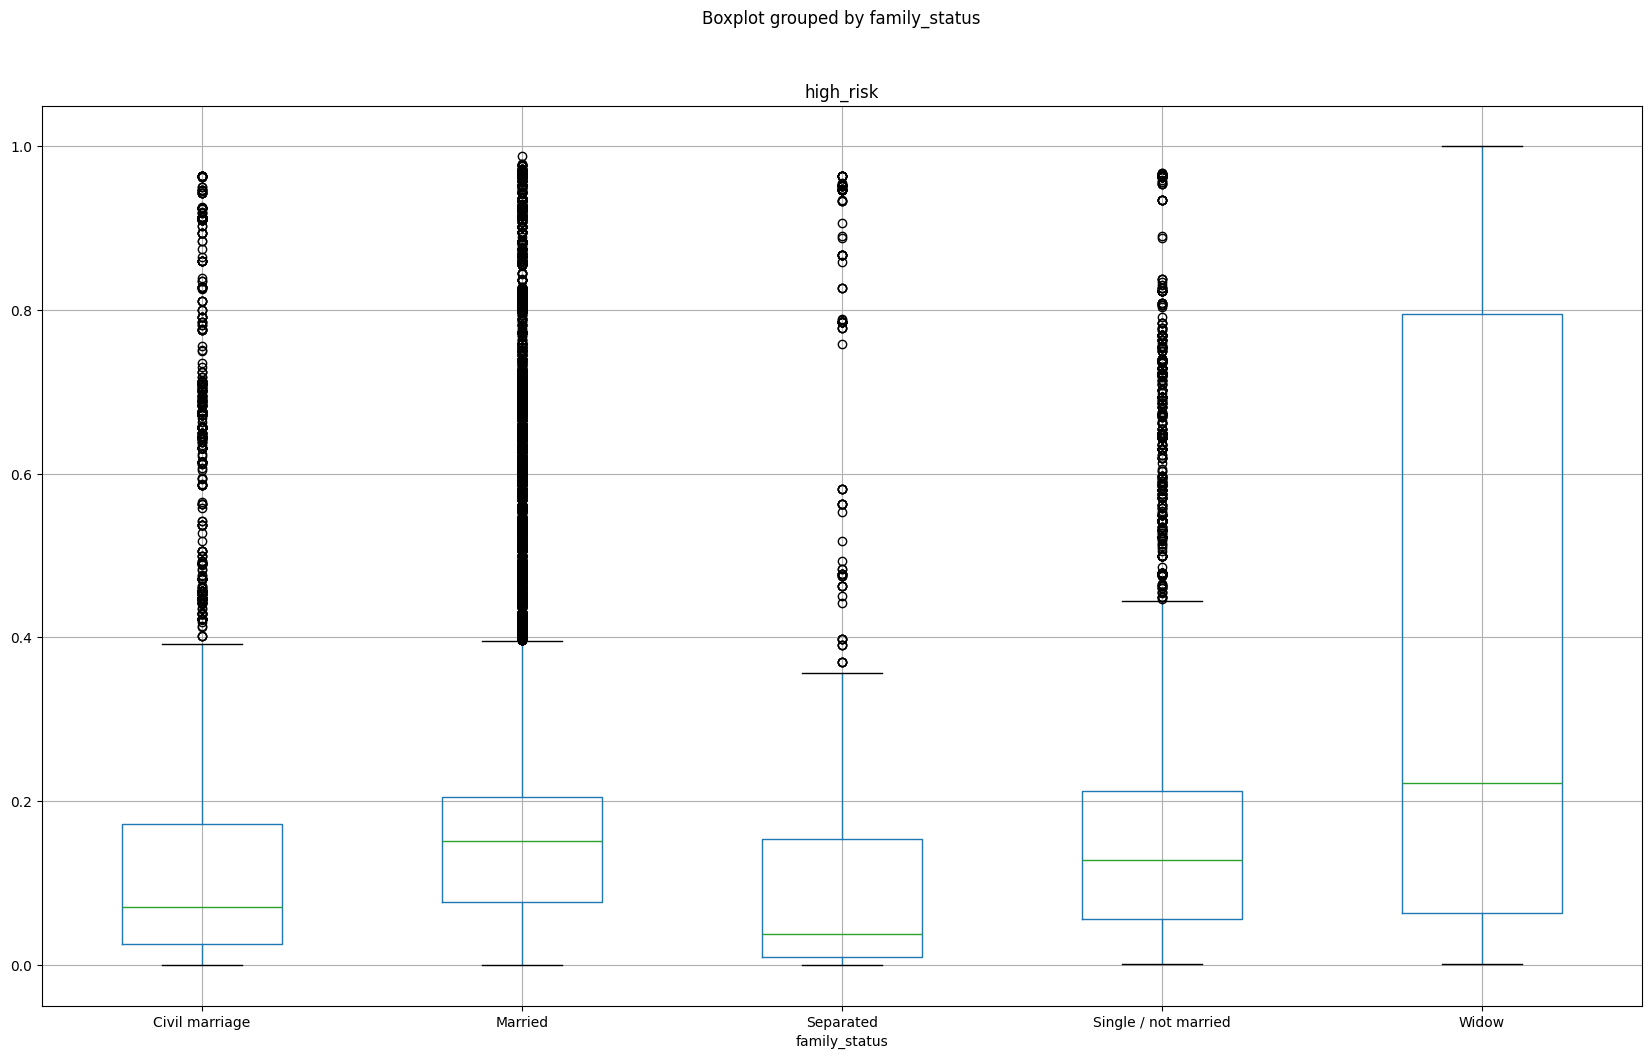

In [143]:
df_original.boxplot(column = "high_risk", by = "family_status", figsize=(20,12))

<Axes: xlabel='income', ylabel='Count'>

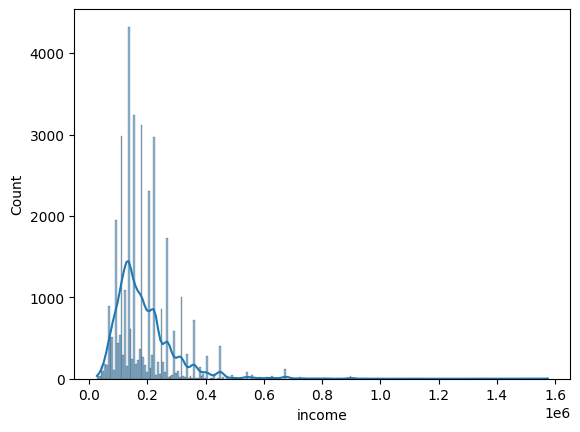

In [144]:
import seaborn as sns  
sns.histplot(df_original["income"], kde=True)

In [145]:
df_filtered = df_original.drop_duplicates(
    subset=df_original.columns.difference(["ID","months_balance"]),  # Excluyo "ID" y "months_balance"
    keep="first"
)

In [146]:
# me aseguro de que todos los datos son de personas unicas eliminando el ID y el months_balance ya que puede ser otra cuenta de la misma persona

In [147]:
df_filtered

,ID,gender,own_car,own_property,children,income,income_type,education_type,family_status,house_type,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,occupation_type,family_members,months_balance,high_risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0.027470
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0.328048
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0.112304
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,-20.0,0.933044
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,-5.0,0.088904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36441,5148694,F,N,N,0,180000.0,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,-20600,-198,1,0,0,0,Laborers,2.0,-20.0,0.874215
36445,5149055,F,N,Y,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15837,-2694,1,1,1,0,NaN,2.0,-19.0,0.143460
36450,5149729,M,Y,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-19101,-1721,1,0,0,0,NaN,2.0,-21.0,0.356909
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,-32.0,0.228543


In [148]:
df_filtered.to_excel("credit_score_predictions4.xlsx", index = False)

In [149]:
df_filtered.describe()

,ID,children,income,age,days_employed,own_mobile_phone,own_work_phone,own_phone,own_email,family_members,months_balance,high_risk
count,9.728000e+03,9728.000000,9.728000e+03,9728.000000,9728.000000,9728.0,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000
mean,5.076082e+06,0.423006,1.812529e+05,-15991.086143,61720.199836,1.0,0.217311,0.287521,0.087479,2.182977,-27.268606,0.200052
std,4.080731e+04,0.767271,9.937549e+04,4246.015221,139646.268047,0.0,0.412437,0.452630,0.282551,0.933058,16.643602,0.213524
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000083
25%,5.036943e+06,0.000000,1.125000e+05,-19564.250000,-2993.500000,1.0,0.000000,0.000000,0.000000,2.000000,-41.000000,0.060081
50%,5.069442e+06,0.000000,1.575000e+05,-15607.000000,-1374.000000,1.0,0.000000,0.000000,0.000000,2.000000,-26.000000,0.144722
75%,5.112985e+06,1.000000,2.250000e+05,-12437.750000,-339.750000,1.0,0.000000,1.000000,0.000000,3.000000,-13.000000,0.220821
max,5.150479e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,0.999987


In [150]:
df_filtered.shape

(9728, 20)